This notebook is part of the $\omega radlib$ documentation: http://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# RADOLAN Quick Start

All RADOLAN composite products can be read by the following function:

```python
data, metadata = wradlib.io.read_radolan_composite("mydrive:/path/to/my/file/filename")
```

Here, ``data`` is a two dimensional integer or float array of shape (number of rows, number of columns). ``metadata`` is a dictionary which provides metadata from the files header section, e.g. using the keys `producttype`, `datetime`, `intervalseconds`, `nodataflag`.

The [RADOLAN Grid](radolan_grid.ipynb) coordinates can be calculated with [wradlib.georef.get_radolan_grid()](http://docs.wradlib.org/en/latest/generated/wradlib.georef.rect.get_radolan_grid.html).

With the following code snippet the RW-product is shown in the [Polar Stereographic Projection](radolan_grid.ipynb#Polar-Stereographic-Projection).

Import modules, filter warnings to avoid cluttering output with DeprecationWarnings and use matplotlib inline or interactive mode if running in ipython or python respectively.

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

In [2]:
# load radolan files
rw_filename = wrl.util.get_wradlib_data_file('radolan/misc/raa01-rw_10000-1408102050-dwd---bin.gz')
rwdata, rwattrs = wrl.io.read_radolan_composite(rw_filename)
# print the available attributes
print("RW Attributes:", rwattrs)

RW Attributes: {'producttype': 'RW', 'datetime': datetime.datetime(2014, 8, 10, 20, 50), 'radarid': '10000', 'datasize': 1620000, 'maxrange': '150 km', 'radolanversion': '2.13.1', 'precision': 0.1, 'intervalseconds': 3600, 'nrow': 900, 'ncol': 900, 'radarlocations': ['boo', 'ros', 'emd', 'hnr', 'umd', 'pro', 'ess', 'asd', 'neu', 'nhb', 'oft', 'tur', 'isn', 'fbg', 'mem'], 'nodataflag': -9999, 'secondary': array([   799,    800,    801, ..., 806263, 806264, 807163]), 'cluttermask': array([], dtype=int64)}


In [3]:
# do some masking
sec = rwattrs['secondary']
rwdata.flat[sec] = -9999
rwdata = np.ma.masked_equal(rwdata, -9999)

In [4]:
# Get coordinates
radolan_grid_xy = wrl.georef.get_radolan_grid(900,900)
x = radolan_grid_xy[:,:,0]
y = radolan_grid_xy[:,:,1]

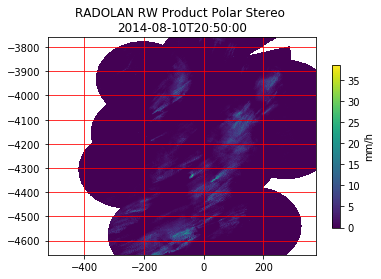

In [5]:
# plot function
pl.pcolormesh(x, y, rwdata, cmap="viridis")
cb = pl.colorbar(shrink=0.75)
cb.set_label("mm/h")
pl.title('RADOLAN RW Product Polar Stereo \n' + rwattrs['datetime'].isoformat())
pl.grid(color='r')

A much more comprehensive section using several RADOLAN composites is shown in chapter [RADOLAN Product Showcase](radolan_showcase.ipynb).